# Localizing Particles using LodeSTAR

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch06_SelfSupervised/ec06_1_lodestar/lodestar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [ ]:
%pip install deeplay deeptrack

## Creating the Dataset

Define a particle located near the center of the image ...

In [27]:
import deeptrack as dt
from numpy.random import uniform

image_size = 51

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

... define the optical system as a fluorescence microscope ...

In [28]:
optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

... create the  simulation pipeline ...

In [29]:
import torch

simulation = (optics(particle) >> dt.NormalizeMinMax()
              >> dt.Gaussian(sigma=0.1) >> dt.MoveAxis(-1, 0)
              >> dt.pytorch.ToTensor(dtype=torch.float32))

In [30]:
train_dataset = dt.pytorch.Dataset(simulation, length=100)
test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)

... and plot some generated particles and their position.

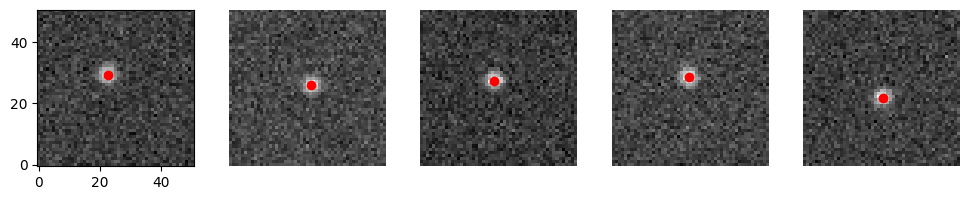

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    image, position = test_dataset[i]
    ax.imshow(image[0], cmap="gray", origin="lower")
    ax.scatter(position[1], position[0], c="r")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

## Learning from Translations

Implement a neural network with a convolutional backbone and a dense top layer ...

In [ ]:
import deeplay as dl

backbone = dl.ConvolutionalNeuralNetwork(
    in_channels=1, hidden_channels=[16, 32, 64], out_channels=128,
    pool=torch.nn.MaxPool2d(2),
)
model = dl.Sequential(backbone, torch.nn.Flatten(), torch.nn.LazyLinear(2))

In [ ]:
from kornia.geometry.transform import translate

def image_translation(batch, translation):
    """Translate a batch of images."""
    xy_flipped_translation = translation[:, [1, 0]]
    return translate(batch, xy_flipped_translation, padding_mode="reflection")

... a function to translate back the output positions ...

In [ ]:
def inverse_translation(preds, applied_translation):
    """Invert translation of predicted positions."""
    return preds - applied_translation

... and a class to implement a self-supervised particle localizer trained with translations ...

In [16]:
from torch import rand

class ParticleLocalizer(dl.Application):
    """LodeSTAR implementation with translations."""

    def __init__(self, model, n_transforms=8, **kwargs):
        """Initialize the ParticleLocalizer."""
        self.model, self.n_transforms = model, n_transforms
        super().__init__(**kwargs)

    def forward(self, batch):
        """Forward pass through the model."""
        return self.model(batch)

    def random_arguments(self):
        """Generate random arguments for transformations."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5)}

    def forward_transform(self, batch, translation):
        """Apply forward translation to the image."""
        return image_translation(batch, translation)

    def inverse_transform(self, preds, translation):
        """Apply inverse translation to the predictions."""
        return inverse_translation(preds, translation)

    def training_step(self, image, batch_idx):
        """Perform a single training step."""
        image, *_ = image
        batch = image.repeat(self.n_transforms, 1, 1, 1)

        kwargs = self.random_arguments()
        transformed_batch = self.forward_transform(batch, **kwargs)

        pred_position = self(transformed_batch)
        pred_position = self.inverse_transform(pred_position, **kwargs)

        average_pred_position = pred_position \
            .mean(dim=0, keepdim=True).repeat(self.n_transforms, 1)
        loss = self.loss(pred_position, average_pred_position)
        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

... instantiate this class ...

In [17]:
localizer = ParticleLocalizer(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=5e-4),
).create()

... and train the self-supervised particle localizer trained with translations.

In [28]:
dataloader = dl.DataLoader(train_dataset, batch_size=1, shuffle=True)
trainer = dl.Trainer(max_epochs=30)
trainer.fit(localizer, dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 97.2 K | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
97.2 K    Trainable params
0         Non-trainable params
97.2 K    Total params
0.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

### Evaluating the Performance

Evaluate the performance of the self-supervised particle localizer trained with translations ...

In [18]:
images, positions = zip(*test_dataset)
images, positions = torch.stack(images), torch.stack(positions)

predictions = localizer(images).detach().numpy()

... implement a function to plot the predicted positions versus the real ones ...

In [20]:
def plot_position_comparison(positions, predictions):
    """Plot comparison between predicted and real particle positions."""
    plt.figure(figsize=(14, 8))
    grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)

    plt.subplot(grid[1:, :3])
    plt.scatter(positions[:, 0], predictions[:, 0], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Horizontal Position", fontsize=20)
    plt.ylabel("Predicted Horizontal Position", fontsize=20)
    plt.axis("equal")

    plt.subplot(grid[1:, 4:])
    plt.scatter(positions[:, 1], predictions[:, 1], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Vertical Position", fontsize=20)
    plt.ylabel("Predicted Vertical Position", fontsize=20)
    plt.axis("equal")

    plt.show()

... and use it to plot the predicted versus real positions.

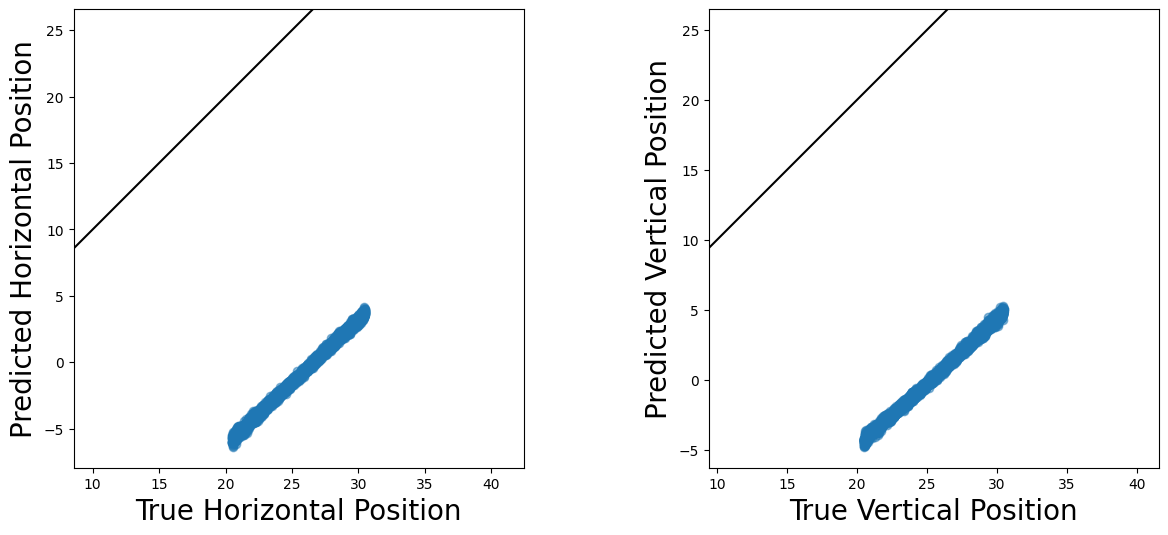

In [31]:
plot_position_comparison(positions, predictions)

## Improving the Predictions Averaging Reflected Images

Correct the bias of a self-supervised particle localizer trained with translations.

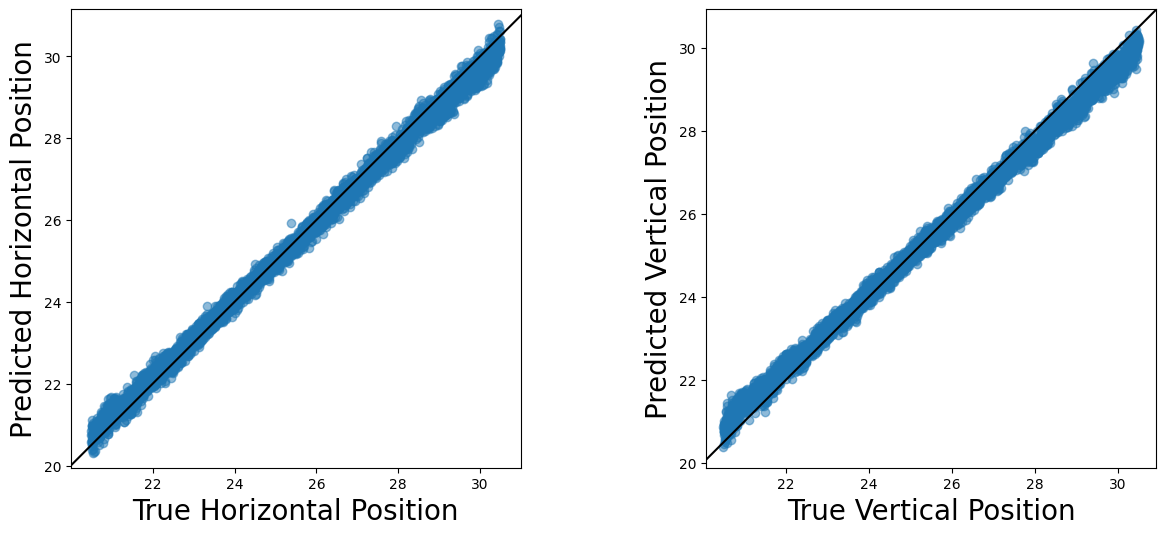

In [32]:
direct_preds = localizer(images).detach().numpy()

flipped_images = images.flip(dims=(2, 3))
flipped_preds = localizer(flipped_images).detach().numpy()

predictions_with_difference = ((direct_preds - flipped_preds) / 2
                               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions_with_difference)

## Learning from Reflections

Implement a function to conditionally reflect images along a specified dimension ...

In [33]:
def flip_transform(batch, should_flip, dim):
    """Conditionally flip batch along a specified dimension."""
    should_flip = should_flip.view(-1, 1, 1, 1)
    return torch.where(should_flip, batch.flip(dims=(dim,)), batch)

... a function to conditionally inverse flip images ...

In [34]:
def inverse_flip_transform(preds, should_flip, dim):
    """Conditionally inverse flip transformation based on should flip."""
    should_flip_mask = torch.zeros_like(preds).bool()
    should_flip_mask[should_flip, dim] = 1
    return torch.where(should_flip_mask, -preds, preds)

... and a class to implement a self-supervised particle localizer trained also with reflections (flips) ...

In [35]:
class ParticleLocalizerWithFlips(ParticleLocalizer):
    """ParticleLocalizer with additional flips."""

    def forward_transform(self, batch, translation, flip_x, flip_y):
        """Apply forward translations and flips to the batch."""
        batch = image_translation(batch, translation)
        batch = flip_transform(batch, flip_x, dim=3)
        batch = flip_transform(batch, flip_y, dim=2)
        return batch

    def inverse_transform(self, preds, translation, flip_x, flip_y):
        """Apply the inverse transformation to the predictions."""
        preds = inverse_flip_transform(preds, flip_x, dim=1)
        preds = inverse_flip_transform(preds, flip_y, dim=0)
        preds = inverse_translation(preds, translation)
        return preds

    def random_arguments(self):
        """Generate random arguments for translations and flips."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "flip_x": rand(self.n_transforms).float().to(self.device) > 0.5,
            "flip_y": rand(self.n_transforms).float().to(self.device) > 0.5}

... train a self-supervised particle localizer with flipping transformations ...

In [36]:
localizer_with_flips = ParticleLocalizerWithFlips(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=1e-3),
).create()
trainer_with_flips = dl.Trainer(max_epochs=30)
trainer_with_flips.fit(localizer_with_flips, dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 97.2 K | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
97.2 K    Trainable params
0         Non-trainable params
97.2 K    Total params
0.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

... and plot the predictions versus real positions for a self-supervised particle localizer with reflections.

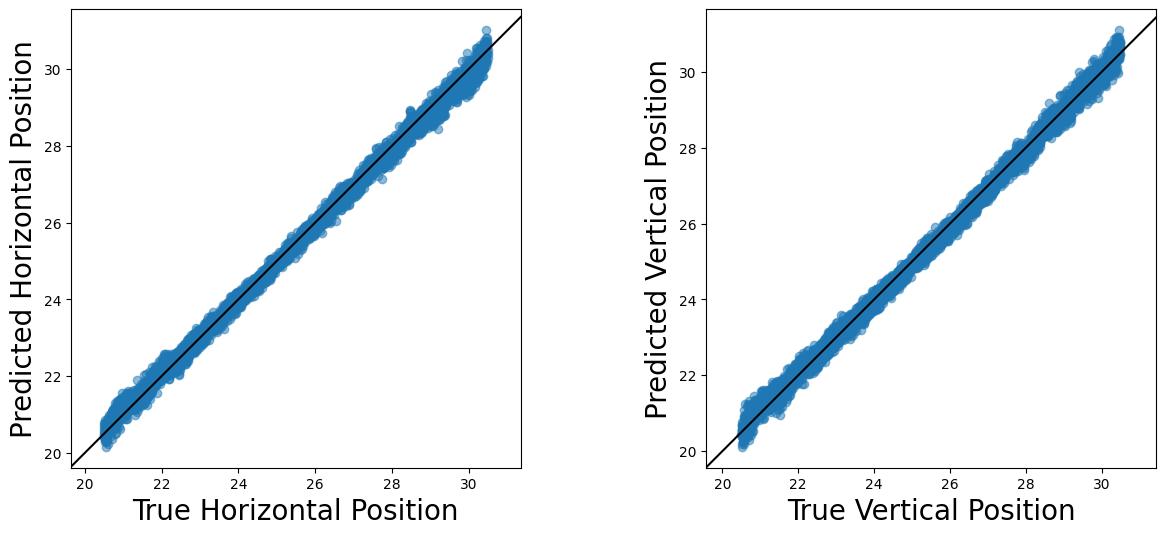

In [37]:
predictions = (localizer_with_flips(images).detach().numpy()
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions)

## Improving Performance with LodeSTAR

Train LodeSTAR ...

In [23]:
dataloader_lodestar = dl.DataLoader(train_dataset, batch_size=2, shuffle=True)

lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()

trainer_lodestar = dl.Trainer(max_epochs=30)
trainer_lodestar.fit(lodestar, dataloader_lodestar)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                       | Params | Mode 
---------------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K  | train
1 | between_loss  | L1Loss                     | 0      | train
2 | within_loss   | L1Loss                     | 0      | train
3 | train_metrics | MetricCollection           | 0      | train
4 | val_metrics   | MetricCollection           | 0      | train
5 | test_metrics  | MetricCollection           | 0      | train
6 | optimizer     | Adam                       | 0      | train
---------------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
39        Modules in train mode
0

Training: |          | 0/? [00:00<?, ?it/s]

... and plot its performance.

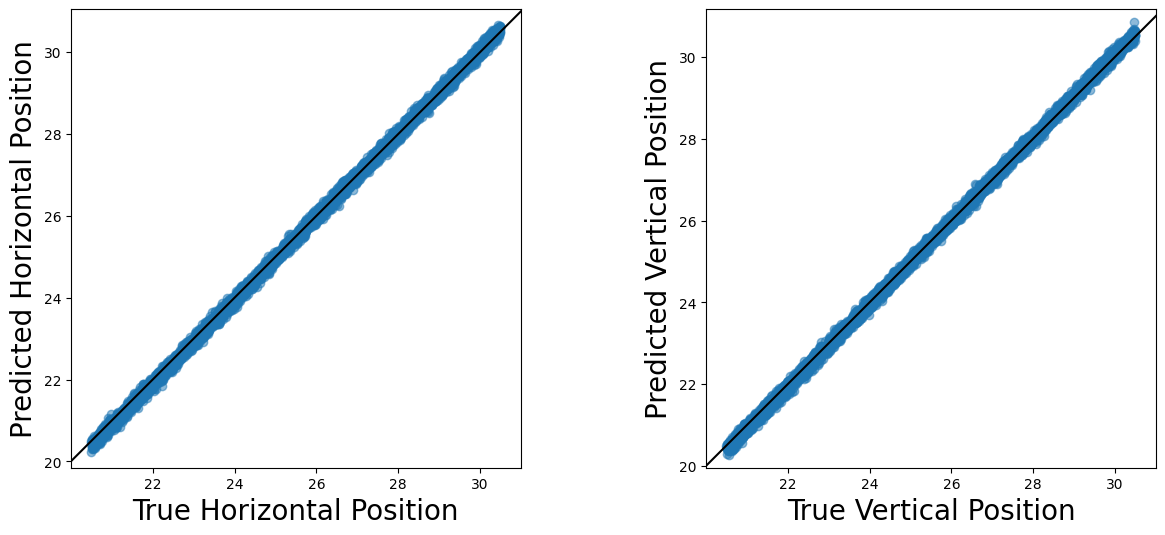

In [39]:
lodestar_predictions = lodestar.pooled(images).detach().numpy()

plot_position_comparison(positions, lodestar_predictions)

In [40]:
# === Inserted: ParticleLocalizerWithRotation and rotation utilities ===

import torch.nn.functional as F
import math

def rotate_transform(images, angles):
    radians = angles * math.pi / 180
    cos = torch.cos(radians)
    sin = torch.sin(radians)
    theta = torch.zeros((images.shape[0], 2, 3), device=images.device)
    theta[:, 0, 0] = cos
    theta[:, 0, 1] = -sin
    theta[:, 1, 0] = sin
    theta[:, 1, 1] = cos
    grid = F.affine_grid(theta, images.size(), align_corners=False)
    return F.grid_sample(images, grid, align_corners=False)

def inverse_rotate_transform(images, angles):
    return rotate_transform(images, -angles)

class ParticleLocalizerWithRotation(ParticleLocalizer):
    """ParticleLocalizer using rotation and translation instead of flips."""

    def forward_transform(self, batch, translation, rotation_angle):
        batch = image_translation(batch, translation)
        batch = rotate_transform(batch, rotation_angle)
        return batch

    def inverse_transform(self, preds, translation, rotation_angle):
    # 将角度转换为弧度
        radians = rotation_angle * math.pi / 180
        cos = torch.cos(radians)
        sin = torch.sin(radians)

        # 构造逆旋转矩阵并应用到每个预测点
        rot = torch.stack([
            torch.stack([cos, sin], dim=1),
            torch.stack([-sin, cos], dim=1)
        ], dim=1)  # shape: [B, 2, 2]

        preds = torch.bmm(rot, preds.unsqueeze(-1)).squeeze(-1)  # 批量矩阵乘法
        preds = inverse_translation(preds, translation)  # 再做反平移
        return preds

    def random_arguments(self):
        return {
            "translation": (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "rotation_angle": (rand(self.n_transforms).float().to(self.device) * 360)
        }



In [41]:
# Initialize rotation-based model
localizer_with_rotation = ParticleLocalizerWithRotation(
    model,
    n_transforms=8,
    loss=torch.nn.L1Loss(),
    optimizer=dl.Adam(lr=1e-3)
).create()

trainer_with_rotation = dl.Trainer(max_epochs=30)
trainer_with_rotation.fit(localizer_with_rotation, dataloader)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 97.2 K | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
97.2 K    Trainable params
0         Non-trainable params
97.2 K    Total params
0.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

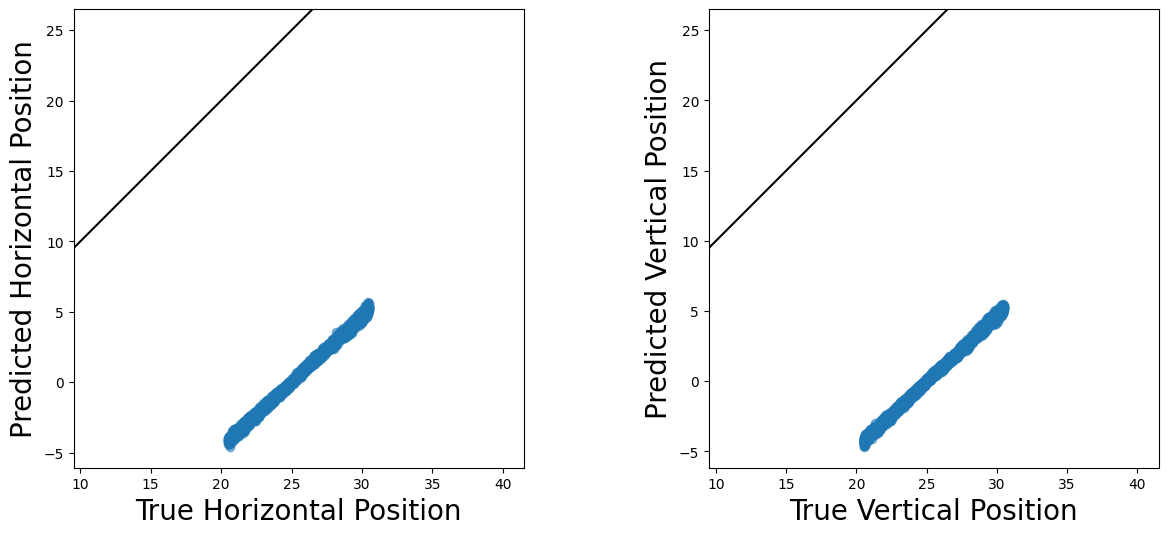

In [42]:
predictions = localizer_with_rotation(images).detach().numpy()
plot_position_comparison(positions, predictions)

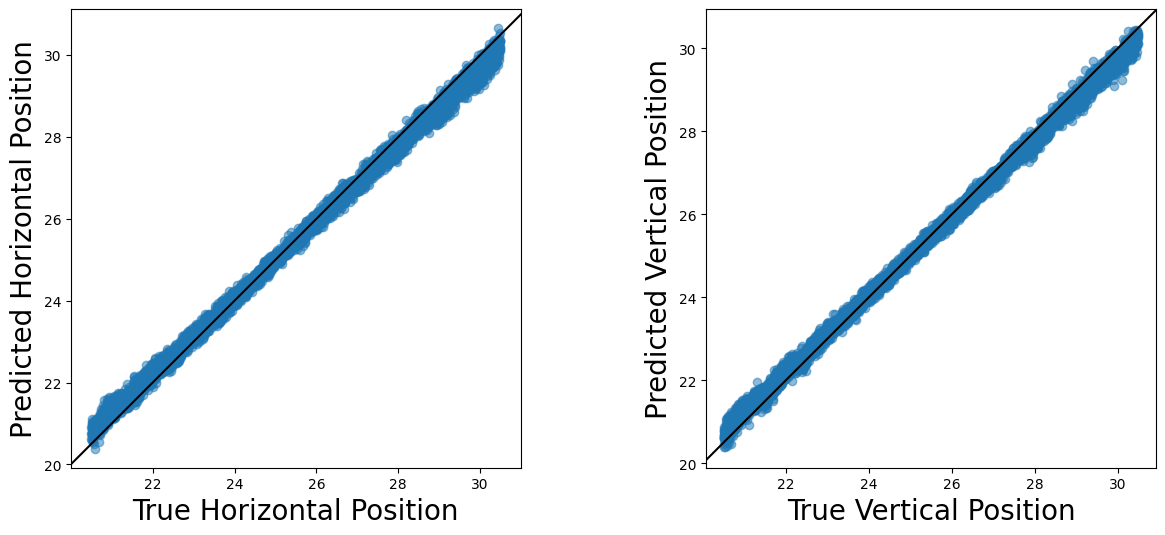

In [43]:
image_center = image_size / 2 - 0.5

# 原始预测
direct_preds = localizer_with_rotation(images).detach().numpy()

# 180°旋转图像并预测
rotated_images = rotate_transform(images, torch.full((images.shape[0],), 180).to(images.device))
rotated_preds = localizer_with_rotation(rotated_images).detach().numpy()

# 坐标中心化（移到图像中心）
rotated_preds_centered = rotated_preds - image_center
# 取负表示旋转180°
rotated_preds_centered = -rotated_preds_centered
# 还原回图像坐标
rotated_preds = rotated_preds_centered + image_center

# 平均两个预测
predictions_avg = (direct_preds + rotated_preds) / 2

# 可视化结果
plot_position_comparison(positions, predictions_avg)


In [26]:
import deeplay as dl
dataloader_lodestar2 = dl.DataLoader(train_dataset, batch_size=2, shuffle=True)

lodestar2 = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()

trainer_lodestar2 = dl.Trainer(max_epochs=30)
trainer_lodestar2.fit(lodestar2, dataloader_lodestar2)

INFO: 
  | Name          | Type                       | Params | Mode 
---------------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K  | train
1 | between_loss  | L1Loss                     | 0      | train
2 | within_loss   | L1Loss                     | 0      | train
3 | train_metrics | MetricCollection           | 0      | train
4 | val_metrics   | MetricCollection           | 0      | train
5 | test_metrics  | MetricCollection           | 0      | train
6 | optimizer     | Adam                       | 0      | train
---------------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Params | Mode 
------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

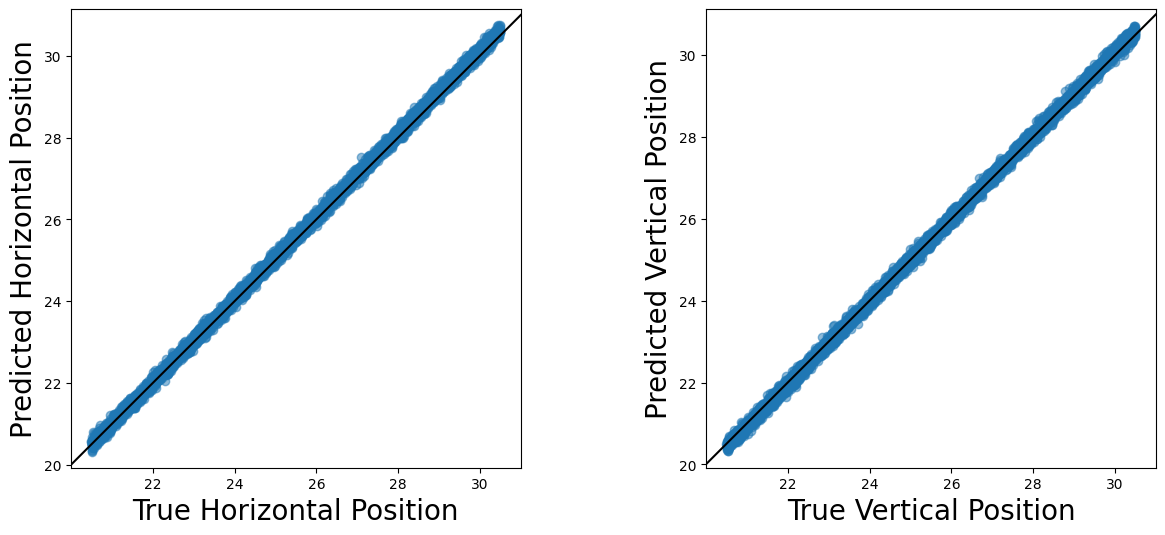

In [21]:
lodestar_predictions2 = lodestar2.pooled(images).detach().numpy()

plot_position_comparison(positions, lodestar_predictions2)

In [25]:

import torch.nn.functional as F
def evaluate_mse(model, images, targets, is_lodestar=False):
    model.eval()
    with torch.no_grad():
        if is_lodestar:
            preds = model.pooled(images)
        else:
            preds = model(images)
        mse = F.mse_loss(preds, targets)
    return mse.item()

mse_lodestar = evaluate_mse(lodestar, images, positions, is_lodestar=True)
mse_lodestar2 = evaluate_mse(lodestar2, images, positions, is_lodestar=True)


print(f"MSE (LodeSTAR): {mse_lodestar:.4f}")
print(f"MSE (LodeSTAR2): {mse_lodestar2:.4f}")



MSE (LodeSTAR): 0.0090
MSE (LodeSTAR2): 0.0114
